# Setup

In [1]:
''' magic 4u'''
%load_ext autoreload
%autoreload 2

In [2]:
'''Get Stuff You Need'''
import numpy as np
import math as math
from tqdm import tnrange
from tqdm.notebook import tqdm as tdqm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import scipy.io
import scipy.ndimage.filters as filt
import pandas as pd
import seaborn as sns

from pipeline import get_data as get
from pipeline import process_spikes as ps

from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
from itertools import combinations

In [3]:
''' Define plotting defaults '''

from matplotlib import rc 
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['svg.fonttype'] = 'none'

In [4]:
''' Define some functions for later '''
def count_consec(lst):
    consec = [1]
    for x, y in zip(lst, lst[1:]):
        if x == y - 1:
            consec[-1] += 1
        else:
            consec.append(1)
    return consec

def tuning_curve_bytrial(x, trial, Y, dt, b, sigma, smooth=True, normalize=False, occupancy=True):
    '''
    Params
    ------
    x : ndarray
        variable of interest by observation; shape (n_obs, )
    trial : ndarray
        trial num for each observation; shape (n_obs, )
    Y : ndarray
        spikes per observation; shape (n_obs, n_cells)
    dt : int
        time per observation in seconds
    b : int
        bin size
    sigma : int
        SD of Gaussian filter
    smooth : bool
        apply gaussian filter to firing rate; optional, default is True
    normalize : bool
        normalize the firing rate of each cell such that its max FR is 1, min is 0;
        optional, default is False
    occupancy : bool
        return occupancy (dwell time in each bin); optional, default is True

    Returns
    -------
    firing_rate : ndarray
        binned firing rate for each trial for each cell; shape (n_trials, n_bins, n_cells)
    centers : ndarray
        center of each bin
    occ : ndarray
       dwell time in each bin; shape (n_bins, n_cells)
    '''
    edges = np.arange(0, np.max(x) + b, b)
    centers = (edges[:-1] + edges[1:])/2
    b_idx = np.digitize(x, edges)
    if np.max(x) == edges[-1]:
        b_idx[b_idx==np.max(b_idx)] = np.max(b_idx) - 1
    unique_bdx = np.unique(b_idx)

    # find FR in each bin
    firing_rate = np.zeros((np.unique(trial).shape[0], unique_bdx.shape[0], Y.shape[1]))
    occ = np.zeros((np.unique(trial).shape[0], unique_bdx.shape[0], Y.shape[1]))
    for j in range(unique_bdx.shape[0]):
        idx1 = (b_idx == unique_bdx[j])
        for i, t in enumerate(np.unique(trial)):
            idx = idx1 & (trial == t)
            if np.sum(idx)==0:
                #print('warning: zero occupancy!')
                firing_rate[i, j, :] = firing_rate[i, j-1, :]
                occ[i, j, :] = 0
            else:    
                spike_ct = np.sum(Y[idx, :], axis=0)
                occupancy = dt * np.sum(idx)
                occ[i, j, :] = occupancy
                firing_rate[i, j, :] = spike_ct / occupancy
    if smooth:
        firing_rate = gaussian_filter1d(firing_rate, sigma, axis=1, mode='wrap')

    if normalize:
        for c in range(firing_rate.shape[2]):
            firing_rate[:, :, c] = (firing_rate[:, :, c] - np.min(firing_rate[:, :, c]))/np.max(firing_rate[:, :, c] - np.min(firing_rate[:, :, c]))
    
    if occupancy:
        return firing_rate, centers, occ
    else: 
        return firing_rate, centers
    
def find8adjacentElements(test_list):
    ''' 
    Params
    ------
    test_list : ndarray
        1d array to be sorted
    
    Returns
    -------
    neighbors : list
        nested list where each element is a list of 8 adjacent elements to the element with the same 
        index in test_list, adjusting for the first and last four elements and not including 
    '''
    
    neighbors = []
    for idx, ele in enumerate(test_list):
    # Checking for all cases to append
        if idx == 0:
            neighbors.append(test_list[(idx+1):(idx + 9)])
        elif idx == 1:
            neighbors.append(np.concatenate((test_list[(idx - 1)],test_list[(idx+1):(idx + 8)]),axis=None))
        elif idx == 2:
            neighbors.append(np.concatenate((test_list[:idx],test_list[(idx+1):(idx + 7)]),axis=None))
        elif idx == 3:
            neighbors.append(np.concatenate((test_list[:idx],test_list[(idx+1):(idx + 6)]),axis=None))
        elif idx == len(test_list) - 1:
            neighbors.append(np.concatenate((test_list[(idx-8):idx]),axis=None))                     
        elif idx == len(test_list) - 2:
            neighbors.append(np.concatenate((test_list[(idx-7):idx],test_list[(idx + 1):]),axis=None))
        elif idx == len(test_list) - 3:
            neighbors.append(np.concatenate((test_list[(idx-6):idx],test_list[(idx + 1):]),axis=None))
        elif idx == len(test_list) - 4:
            neighbors.append(np.concatenate((test_list[(idx-5):idx],test_list[(idx + 1):]),axis = None))
        else:
            neighbors.append(np.concatenate((test_list[(idx - 4):idx],test_list[(idx+1):(idx + 5)]),axis=None))
    return neighbors 

def find(x):
    return x.nonzero()[0]

def autocorr(x,lags):
    '''numpy.correlate'''
    mean=x.mean()
    var=np.var(x)
    xp=x-mean
    corr=np.correlate(xp,xp,'full')[len(x)-1:]/var/len(x)

    return corr[:len(lags)]

In [5]:
''' Load in Animal Metadata '''

animalmeta = pd.read_csv('C:/Users/Python/Desktop/Dryad/MouseMetadata.csv') # adjust path name

# define some useful lists of animals based on metadata
all_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3),'Animal_ID'])
all_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2),'Animal_ID'])
all_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1),'Animal_ID'])

cohorta_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'A'),'Animal_ID'])
cohortb_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'B'),'Animal_ID'])
cohortc_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'C'),'Animal_ID'])
cohortd_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'D'),'Animal_ID'])

RF_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'SM'),'Animal_ID'])

all_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F'),'Animal_ID'])
all_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M'), 'Animal_ID'])
RF_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'SM'),'Animal_ID'])

animalmeta.head()

,Animal_ID,Task,Cohort,Probe_Control,Sex,Sac_Date,Frozen_Hemisphere,DOB,Age_WholeMonth,Age_ExtraDays,Age_Month,Aged_Days,Age_Group,Behavior_Sessions,Neural_Sessions
0,A3,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
1,A4,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
2,A5,RF,A,0,F,4/6/2021,L,4/23/2019,23,14,23.487,714,3,6,6
3,A6,RF,A,0,F,4/6/2021,R,4/23/2019,23,14,23.487,714,3,6,6
4,A7,RF,A,0,F,4/19/2021,L,5/29/2019,22,21,22.730,691,3,6,6


In [6]:
'''Load Session Metadata'''
sessionmeta = pd.read_csv('C:/Users/Python/Desktop/LocalData/sessionmeta.csv')
print(sessionmeta.head())

                                    File Animal_ID  Session  Sync  \
0  A3_210122_randomforagecuerich_record1        A3      1.0   1.0   
1  A3_211023_randomforagecuerich_record2        A3      2.0   1.0   
2  A3_211024_randomforagecuerich_record3        A3      3.0   1.0   
3  A3_210125_randomforagecuerich_record4        A3      4.0   1.0   
4  A3_210126_randomforagecuerich_record5        A3      5.0   1.0   

   Final Depth (D) Final Depth (V)  Angle   Difficulty SyncBlock  \
0           3510.0            3450   10.61         0.0         2   
1           3637.0            3575   10.59         0.0         2   
2           4120.0            4050   10.58         0.0         2   
3           3917.0            3850   10.61         0.0         2   
4           3765.0            3700   10.66         0.0         2   

           Notes  
0  Pulse amp low  
1  Pulse amp low  
2  Pulse amp low  
3  Pulse amp low  
4  Pulse amp low  


In [7]:
''' Complete List of Mice & Sessions '''
all_mice = np.array(animalmeta.Animal_ID)

all_sessions = ([['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'], 
             ['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'],
             ['0401_record1','0401_record2b','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0401_record1','0402_record2','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0414_record1','0415_record2','0416_record3','0417_record4','0418_record5','0419_record6'],
             ['1024_record1','1025_record2','1026_record3','1027_record4','1028_record5_2'], #Y2_6 excluded
             ['1016_record1','1019_record3','1020_record4','1021_record5','1022_record6'], #Y3_2 not collected
             ['1114_record1','1115_record2','1116_record3','1117_record4','1118_record5','1119_record6'], # end cohort A
             ['051822_record1','051922_record2', '052022_record3','052122_record4','052222_record5','052322_record6'], 
             ['050522_record1','050622_record2','050722_record3','050822_record4','050922_record5','051022_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','051022_record6'], #Y11_5 not collected
             ['062222_record3','062322_record4','062522_record5'], #Y16_1 & 2 not collected, neural _6 excluded
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'],
             ['062022_record1','062122_record2','062222_record3','062322_record4','062522_record5','062622_record6'],
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'], 
             ['051922_record2','052022_record3'], # Y9 051822_record excluded for syncing issue, end cohort B
             ['083022_record1','083122_record2','090122_record3'], 
             ['083022_record1','083122_record2','090122_record3','090222_record4','090322_record5','090422_record6'],
             ['083022_record1','083122_record2','090122_record3','090222_record4'], #behavior of A16_4, both of 5 excluded, 6 not collected 
             ['082322_record1','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['082322_record1real','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['103122_record2','110122_record3','110222_record4','110322_record5rep','110422_record6','110522_record7'], #behavior of MA4M6, 7 excluded
             ['110622_record1','110722_record2','110822_record3','110922_record4','111022_record5','111122_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4','110322_record5','110422_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4'], #behavior of MA7_4, both 5 excluded, 6 not collected
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'], 
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'], #end cohortc
             ['012723_record2','012823_record3','012923_record4','013023_record5','013123_record6','020123_record7'],
             ['012623_record1','012723_record2','012823_record3','012923_record4','013023_record5','013123_record6'],
             ['012923_record2','013023_record3','013123_record4','020123_record5','020223_record6','020323_record7'],
             ['020923_record1','021023_record2','021123_record3','021223_record4','021323_record5','021423_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5rep','022123_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'] #end cohort d 
            ]) #list of sessions

In [8]:
'''Define which mice & sessions to load'''
mice = all_mice
sessions = all_sessions
    
# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

In [12]:
''' Gather waveform properties of putative excitatory vs. inhibitory interneurons '''

load_folder = 'C:/Users/Python/Desktop/LocalData/intnspeedcells/' # adjust to output of Shuffle Procedure notebook
dataload_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' #adjust to output of Import/Filter notebook
folder = 'C:/Users/Python/Desktop/Dryad/waveform_metrics/' # adjust to location of downloaded metrics folders

PTRe = []
PTRi = []
duratione = []
durationi = []

for m, session in zip(mice,sessions):
    
    seshcount = 1 
    
    for s in session:
        d = data[m][s]
        
        #load in session data & waveform metrics data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(dataload_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
 
        file_name = m + '_' + str(seshcount) + '_metrics.csv'
        metrics = pd.read_csv(folder + file_name)
        
        # load waveform parameters of interest for good cells only, drop rows w/ NaN, standardize for kmeans clustering
        gcmetrics = metrics[metrics['cluster_id'].isin(list(cell_IDs))]
        duration = np.asarray(gcmetrics['duration'])
        PTR = np.asarray(gcmetrics['PT_ratio'])
        halfwidth = np.asarray(gcmetrics['halfwidth'])
        recslope = np.asarray(gcmetrics['recovery_slope'])
        firingrate = np.asarray(gcmetrics['firing_rate'])
        
        #get file name & load int file
        intn_file = 'intn_' + m + '_' + s + '.npy'
        d['intn'] = np.load(load_folder + intn_file, allow_pickle = True)
        intn = d['intn'].astype(bool)
        
        PTRe = np.append(PTRe, PTR[~intn])
        PTRi = np.append(PTRi, PTR[intn])
        duratione = np.append(duratione, duration[~intn])
        durationi = np.append(durationi, duration[intn])
        
        seshcount += 1

In [9]:
'''Get Indices of Stored Session, Animal Data Mice by Age Group'''
age_ind = []
ma_ind = []
y_ind = []
age_sind = []
ma_sind = []
y_sind = []

s_count = 0
for m, s in zip(mice, sessions):
    start = s_count
    end = len(s) + s_count

    if m in all_aged_mice:
        age_ind = np.append(age_ind, (np.where(mice == m)[0]))
        age_sind = np.append(age_sind, np.arange(start, end, 1))
    elif m in all_MA_mice:
        ma_ind = np.append(ma_ind, (np.where(mice == m)[0]))
        ma_sind = np.append(ma_sind, np.arange(start, end, 1))
    else:
        y_ind = np.append(y_ind, (np.where(mice == m)[0]))
        y_sind = np.append(y_sind, np.arange(start, end, 1))
                            
    s_count += len(s)
    
age_ind = age_ind.astype(int)
ma_ind = ma_ind.astype(int)
y_ind = y_ind.astype(int)
age_sind = age_sind.astype(int)
ma_sind = ma_sind.astype(int)
y_sind = y_sind.astype(int)

In [10]:
''' Define ColorMaps for Session & Animal Boxplots '''
import matplotlib.pylab as pl
import matplotlib.lines as mlines

col_animal_old = pl.cm.Oranges([np.linspace(0.2,0.9,17)])
col_animal_MA = pl.cm.Greens([np.linspace(0.2,0.9,10)])
col_animal_young = pl.cm.Blues([np.linspace(0.2,0.9,18)])
col_animal = [col_animal_young, col_animal_MA, col_animal_old]

col_session_young = []
col_session_MA = []
col_session_old = []

for m, session in zip(mice, sessions):
    for s in range(0,len(session)):
        
        if m in all_aged_mice:
            idx = np.where(all_aged_mice == m)[0][0] 
            col_session_old.append(col_animal[2][0][idx])           
        elif m in all_MA_mice:
            idx = np.where(all_MA_mice == m)[0][0]
            col_session_MA.append(col_animal[1][0][idx])
        else:
            idx = np.where(all_young_mice == m)[0][0]
            col_session_young.append(col_animal[0][0][idx])

col_session = [col_session_young, col_session_MA, col_session_old]
label_mice = ['Y2','Y3','Y4','Y11','Y16','Y17','Y18','Y19','Y9', 'Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28',
            'MA1F', 'MA2F', 'MA3M', 'MA4M', 'MA5M', 'MA6M', 'MA7M', 'MA8F', 'MA9F','MA10F',"","","","","","","",
            'A3','A4','A5','A6','A7','A12','A13','A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A22', 'A23', 'A24']

# Examine interneuron density & waveform properties (Figure S6B-D).

Please note you will have had to previously run Shuffle Procedure & Interneuron Classification notebook, which generates the interneuron boolean loaded below and plots Figure S6A.


n EXC cells, IN cells: 
49193 15123

mean, sem excitatory cell waveform duration:
0.5806928618695164 0.0005398911083749179
mean, sem IN cell waveform duration:
0.24317216327811325 0.0004770471659317089
stat = 185.94645996738723
p_cells = 0.0


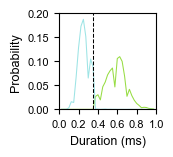


mean, sem excitatory cell waveform PTR:
0.44453274345353794 0.0009823209778073623
mean, sem IN waveform PTR:
0.6245140087498517 0.0033966498250377793
stat = -91.18738056878496
p_cells = 0.0


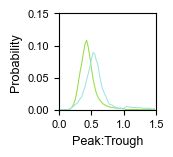

In [18]:
''' For putative interneurons vs. excitatory cells, plot distribution of waveform durations & peak/trough ratios (Figure S6B/C) '''
save_folder = 'C:/Users/Python/Desktop/LocalData/intnspeedcells/'

colors = ['#9DE4E5','#97DD43']

#STATS
print('\nn EXC cells, IN cells: ')
print(len(duratione), len(durationi))

#duration EXC vs. IN
print('\nmean, sem excitatory cell waveform duration:')
print(np.nanmean(duratione), stats.sem(duratione, nan_policy = 'omit')) 
print('mean, sem IN cell waveform duration:')
print(np.nanmean(durationi), stats.sem(durationi, nan_policy = 'omit')) 
stat, p_diff = stats.ranksums(duratione, durationi)
print('stat = '+ str(stat))
print('p_cells = ' + str(p_diff))

# Figure S6b
fig, ax = plt.subplots(figsize = (1.25,1.25))
bins = np.arange(0,1,0.025)

#excitatory cells
bscore, bin_edges = np.histogram(duratione, bins = bins)
pdf = bscore / sum(bscore)

ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = colors[1])

#inhibitory cells
score, bin_edges = np.histogram(durationi, bins = bins)
pdf = score / sum(score)

ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = colors[0])

#format plot
ax.set_ylabel('Probability', fontsize = 9)
ax.set_xlabel('Duration (ms)', fontsize = 9)
ax.set_xlim([0,1])
ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax.set_ylim([0,0.2])
ax.tick_params(labelsize = 8)
ax.vlines(0.35,0,ax.get_ylim()[1],linewidth = 0.75, color = 'k', linestyles = '--')

#plt.savefig(save_folder + 'waveformduration.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'waveformduration.svg', dpi=400, bbox_inches='tight')
plt.show()

#STATS
#PTR EXC vs. IN
print('\nmean, sem excitatory cell waveform PTR:')
print(np.nanmean(PTRe), stats.sem(PTRe, nan_policy = 'omit')) 
print('mean, sem IN waveform PTR:')
print(np.nanmean(PTRi), stats.sem(PTRi, nan_policy = 'omit')) 
stat, p_diff = stats.ranksums(PTRe, PTRi)
print('stat = '+ str(stat))
print('p_cells = ' + str(p_diff))

# Plot Figure S6c
fig, ax = plt.subplots(figsize = (1.25,1.25))
bins = np.arange(0,1.5,0.025)

#excitatory cells
bscore, bin_edges = np.histogram(PTRe, bins = bins)
pdf = bscore / sum(bscore)

ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = colors[1])

#inhibitory cells
score, bin_edges = np.histogram(PTRi, bins = bins)
pdf = score / sum(score)

ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = colors[0])

#format plot
ax.set_ylabel('Probability', fontsize = 9)
ax.set_xlabel('Peak:Trough', fontsize = 9)
ax.set_xlim([0,1.5])
ax.set_xticks([0,0.5,1.0,1.5])
ax.set_ylim([0,0.15])
ax.tick_params(labelsize = 8)
#plt.savefig(save_folder + 'waveformPTR.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'waveformPTR.svg', dpi=400, bbox_inches='tight')
plt.show()


In [21]:
''' Gather Session Average IN Waveform Properties by Age Group '''

load_folder = 'C:/Users/Python/Desktop/LocalData/intnspeedcells/' # adjust to output of Shuffle Procedure notebook
dataload_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' #adjust to output of Import/Filter notebook
folder = 'C:/Users/Python/Desktop/Dryad/waveform_metrics/' # adjust to location of downloaded metrics folders

# pooling arrays
PTRa = []
PTRma = []
PTRy = []
FRa = []
FRma = []
FRy = []
widtha = []
widthma = []
widthy = []
durationa = []
durationma = []
durationy = []

#session arrays
sPTR = []
sFR = []
sduration = []
swidth = []
sint = []
mint = []

allwidth = []
allduration = []

for m, session in zip(mice,sessions):
    
    seshcount = 1 #should actually be 1 
    ints = []
    cells = []
    widths = []
    durations = []
    
    for s in session:
        d = data[m][s]
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(dataload_folder + rawdata_file, allow_pickle=True)
        
        metric_file_name = m + '_' + str(seshcount) + '_metrics.csv'
        cell_IDs = raw.item().get('cellsfil')
        
        # load waveform parameters of interest for good cells only
        metrics = pd.read_csv(folder + metric_file_name)
        gcmetrics = metrics[metrics['cluster_id'].isin(list(cell_IDs))]
        duration = np.asarray(gcmetrics['duration'])
        PTR = np.asarray(gcmetrics['PT_ratio'])
        halfwidth = np.asarray(gcmetrics['halfwidth'])
        recslope = np.asarray(gcmetrics['recovery_slope'])
        firingrate = np.asarray(gcmetrics['firing_rate'])
        
        #get file name & load int file
        intn_file = 'intn_' + m + '_' + s + '.npy'
        d['intn'] = np.load(load_folder + intn_file, allow_pickle = True)
        intn = d['intn'].astype(bool)
        
        #collect data to be pooled across animals
        ints = np.append(ints, np.sum(intn))
        cells = np.append(cells, len(cell_IDs))
        widths = np.append(widths, halfwidth[intn])
        durations = np.append(durations, duration[intn])
        
        #save out session values
        sint = np.append(sint, 100*np.sum(intn)/len(cell_IDs))
        sPTR = np.append(sPTR, np.mean(PTR[intn]))
        sFR = np.append(sFR, np.mean(firingrate[intn]))
        swidth = np.append(swidth, np.nanmean(halfwidth[intn]))
        sduration = np.append(sduration, np.mean(duration[intn]))
        
        #collect data to be pooled across all sessions, animals in age groups
        if m in all_aged_mice:
            PTRa = np.append(PTRa, PTR[intn])
            FRa = np.append(FRa, firingrate[intn])
            widtha = np.append(widtha, halfwidth[intn])
            durationa = np.append(durationa, duration[intn])
        elif m in all_MA_mice:
            PTRma = np.append(PTRma, PTR[intn])
            FRma = np.append(FRma, firingrate[intn])
            widthma = np.append(widthma, halfwidth[intn])
            durationma = np.append(durationma, duration[intn])
        else:
            PTRy = np.append(PTRy, PTR[intn])
            FRy = np.append(FRy, firingrate[intn])
            widthy = np.append(widthy, halfwidth[intn])
            durationy = np.append(durationy, duration[intn])
            
        seshcount += 1
        
    mint = np.append(mint, (100* np.sum(ints) / np.sum(cells)))
    allwidth = np.append(allwidth, widths)
    allduration = np.append(allduration, durations)

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Python\AppData\Local\Temp\ipykernel_23344\3692251035.py:72: RuntimeWarning: Mean of empty slice
  swidth = np.append(swidth, np.nanmean(halfwidth[intn]))


In [22]:
''' Find where I will have NaNs due to 0% INs in a given session'''
nan_idx = np.where((sint == 0))[0]

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sindIN = np.setdiff1d(y_sind, nan_idx)
ma_sindIN = np.setdiff1d(ma_sind, nan_idx)
age_sindIN = np.setdiff1d(age_sind, nan_idx)

# Adjust colormaps for all thresholds
yidx = []
maidx = []
aidx = []
for i in nan_idx:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))
    
col_session_youngIN = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_maIN = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_oldIN = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_sessionIN = [col_session_youngIN, col_session_maIN, col_session_oldIN]      

# This will fix how session stats & box plots are plotted, ensuring color schemes are adjusted.

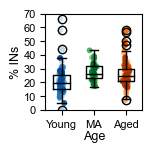

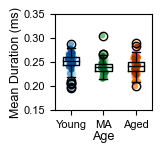

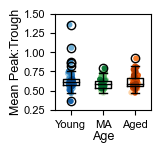

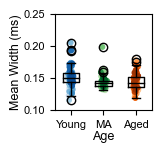

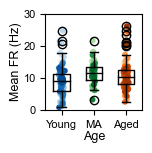

In [25]:
''' Plot Figure S6D Panels (IN Density & Waveform Properties) '''

# set up handles
from itertools import repeat
handles = []
percint = [mint[y_ind], mint[ma_ind], mint[age_ind]]
for i in range(len(percint)):
    for c in col_animal[i][0]:
        dot = mlines.Line2D([],[], color = c, marker ='o', linestyle = 'None', markersize = 8)
        handles.append(dot)
        if c[0] == col_animal[1][0][9][0]: # adds white space so columns are color sorted
            l = mlines.Line2D([0],[0],color="w")
            handles.extend(repeat(l,7))

#Plot Figure S6d (first)
fig, ax = plt.subplots(figsize = (1.25,1.25))
percint = [sint[y_sind], sint[ma_sind], sint[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(percint, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(percint)):
    y = percint[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i][:len(y)], edgecolors = col_session[i][:len(y)], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('% INs', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,70])
ax.set_yticks([0,10,20,30,40,50,60,70])
#plt.savefig(save_folder + 'age_percint_session.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'age_percint_session.svg', dpi=400, bbox_inches='tight')
plt.show()

#Plot Figure S6D (second)
fig, ax = plt.subplots(figsize = (1.25,1.25))
intdur = [sduration[y_sindIN], sduration[ma_sindIN], sduration[age_sindIN]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(intdur, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(intdur)):
    y = intdur[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_sessionIN[i], edgecolors = col_sessionIN[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Duration (ms)', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0.15,0.35])
ax.set_yticks([0.15,0.20,0.25,0.30,0.35])
#plt.savefig(save_folder + 'age_intduration_session.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'age_intduration_session.svg', dpi=400, bbox_inches='tight')
plt.show()

#Plot Figure S6D (middle)
fig, ax = plt.subplots(figsize = (1.25,1.25))
intPTR = [sPTR[y_sindIN], sPTR[ma_sindIN], sPTR[age_sindIN]]
plt.boxplot(intPTR, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(intPTR)):
    y = intPTR[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_sessionIN[i], edgecolors = col_sessionIN[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Peak:Trough', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0.25, 1.50])
ax.set_yticks([0.25,0.50,0.75,1.0,1.25,1.50])
#plt.savefig(save_folder + 'age_intPTR_session.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'age_intPTR_session.svg', dpi=400, bbox_inches='tight')
plt.show()

#Plot Figure S6D (fourth)
fig, ax = plt.subplots(figsize = (1.25,1.25))
intwidth = [swidth[y_sindIN], swidth[ma_sindIN], swidth[age_sindIN]]
plt.boxplot(intwidth, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(intwidth)):
    y = intwidth[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_sessionIN[i], edgecolors = col_sessionIN[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Width (ms)', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0.10,0.25])
ax.set_yticks([0.10,0.15,0.20,0.25])
#plt.savefig(save_folder + 'age_intwidth_session.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'age_intwidth_session.svg', dpi=400, bbox_inches='tight')
plt.show()

#Plot Figure S6D (last)
fig, ax = plt.subplots(figsize = (1.25,1.25))
intFR = [sFR[y_sindIN], sFR[ma_sindIN], sFR[age_sindIN]]
plt.boxplot(intFR, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(intFR)):
    y = intFR[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_sessionIN[i], edgecolors = col_sessionIN[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean FR (Hz)', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,30])
ax.set_yticks([0,10,20,30])
#plt.savefig(save_folder + 'age_meanintFR_session.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'age_meanintFR_session.svg', dpi=400, bbox_inches='tight')
plt.show()

In [32]:
'''Statistics for Multiple Comparisons for IN Density (Figure S6D (first))'''

print('n young, MA, aged sessions: ')
print(len(y_sind),len(ma_sind), len(age_sind))

print('\n%intyoung ± SEM; %int_MA ± SEM; %int_old ± SEM')
print(str(np.round(np.mean(sint[y_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sint[y_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sint[ma_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sint[ma_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sint[age_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sint[age_sind]), 4)))

stat, p_diff = stats.kruskal(sint[y_sind],sint[ma_sind],sint[age_sind])
print('KW stat = ' + str(stat))
print('p_%intsession = ' + str(p_diff))

import statsmodels.api as sm
import scikit_posthocs as ph

#make into dataframe
seshmice = []
seshcount = []
seshage = []
for m, session in zip(mice, sessions):
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    totalsesh = len(session)
    
    for i, s in enumerate(session):
        seshmice = np.append(seshmice, m)
        seshcount = np.append(seshcount, (i + 1))
        seshage = np.append(seshage, age)

# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind,ma_sind,age_sind))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Percentint = list(sint[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Percentint))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','percentint'])
df = df.dropna(axis = 0)

#run post hoc tests
ph.posthoc_conover(df, val_col = 'percentint', group_col = 'AgeGroup', p_adjust = 'holm')

n young, MA, aged sessions: 
98 58 97

%intyoung ± SEM; %int_MA ± SEM; %int_old ± SEM
21.2188 ± 0.9206 ; 27.3493 ± 0.8074 ; 26.2412 ± 0.8678
KW stat = 39.214030539662346
p_%intsession = 3.053384254495053e-09


,1.0,2.0,3.0
1.0,1.000000e+00,1.182298e-08,4.928001e-07
2.0,1.182298e-08,1.000000e+00,1.316514e-01
3.0,4.928001e-07,1.316514e-01,1.000000e+00


In [33]:
'''Statistics for Multiple Comparisons for IN Waveform Duration (Figure S6D (second))'''

print('\nn young, MA, aged w/ INs: ')
print(len(y_sindIN),len(ma_sindIN), len(age_sindIN))

print('\nDurationyoung ± SEM; Duration_MA ± SEM; Duration_old ± SEM')
print(str(np.round(np.mean(sduration[y_sindIN]), 4)) + ' ± ' + str(np.round(stats.sem(sduration[y_sindIN]), 4)) + ' ; ' 
      + str(np.round(np.mean(sduration[ma_sindIN]), 4)) + ' ± ' + str(np.round(stats.sem(sduration[ma_sindIN]), 4)) + ' ; ' 
      + str(np.round(np.mean(sduration[age_sindIN]), 4)) + ' ± ' + str(np.round(stats.sem(sduration[age_sindIN]), 4)))

stat, p_diff = stats.kruskal(sduration[y_sindIN],sduration[ma_sindIN],sduration[age_sindIN])
print('KW stat = ' + str(stat))
print('p_durationsession = ' + str(p_diff))

# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sindIN,ma_sindIN,age_sindIN))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Duration = list(sduration[allidx])
PTR = list(sPTR[allidx])
Width = list(swidth[allidx])
Meanfr = list(sFR[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Duration, PTR, Width, Meanfr))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','duration','ptr','width', 'meanfr'])
df = df.dropna(axis = 0)

#run post hoc tests
ph.posthoc_conover(df, val_col = 'duration', group_col = 'AgeGroup', p_adjust = 'holm')


n young, MA, aged w/ INs: 
97 58 97

Durationyoung ± SEM; Duration_MA ± SEM; Duration_old ± SEM
0.2481 ± 0.0018 ; 0.2406 ± 0.0019 ; 0.2402 ± 0.0016
KW stat = 22.58872170239936
p_durationsession = 1.2442894122603834e-05


,1.0,2.0,3.0
1.0,1.000000,0.000136,0.000063
2.0,0.000136,1.000000,0.764698
3.0,0.000063,0.764698,1.000000


In [34]:
'''Statistics for Multiple Comparisons for IN Waveform PTR (Figure S6D (middle))'''

print('\nPTRyoung ± SEM; PTR_MA ± SEM; PTR_old ± SEM')
print(str(np.round(np.mean(sPTR[y_sindIN]), 4)) + ' ± ' + str(np.round(stats.sem(sPTR[y_sindIN]), 4)) + ' ; ' 
      + str(np.round(np.mean(sPTR[ma_sindIN]), 4)) + ' ± ' + str(np.round(stats.sem(sPTR[ma_sindIN]), 4)) + ' ; ' 
      + str(np.round(np.mean(sPTR[age_sindIN]), 4)) + ' ± ' + str(np.round(stats.sem(sPTR[age_sindIN]), 4)))

stat, p_diff = stats.kruskal(sPTR[y_sindIN],sPTR[ma_sindIN],sPTR[age_sindIN])
print('KW stat = ' + str(stat))
print('p_PTRsession = ' + str(p_diff))

#run post hoc tests
ph.posthoc_conover(df, val_col = 'ptr', group_col = 'AgeGroup', p_adjust = 'holm')


PTRyoung ± SEM; PTR_MA ± SEM; PTR_old ± SEM
0.6281 ± 0.0121 ; 0.5905 ± 0.0083 ; 0.6166 ± 0.0079
KW stat = 5.830669281773567
p_PTRsession = 0.05418589518262913


,1.0,2.0,3.0
1.0,1.000000,0.059076,0.66266
2.0,0.059076,1.000000,0.10001
3.0,0.662660,0.100010,1.00000


In [35]:
'''Statistics for Multiple Comparisons for IN Waveform Width (Figure S6D (fourth))'''

print('\nWidthyoung ± SEM; Width_MA ± SEM; Width_old ± SEM')
print(str(np.round(np.mean(swidth[y_sindIN]), 4)) + ' ± ' + str(np.round(stats.sem(swidth[y_sindIN]), 4)) + ' ; ' 
      + str(np.round(np.mean(swidth[ma_sindIN]), 4)) + ' ± ' + str(np.round(stats.sem(swidth[ma_sindIN]), 4)) + ' ; ' 
      + str(np.round(np.mean(swidth[age_sindIN]), 4)) + ' ± ' + str(np.round(stats.sem(swidth[age_sindIN]), 4)))

stat, p_diff = stats.kruskal(swidth[y_sindIN],swidth[ma_sindIN],swidth[age_sindIN])
print('KW stat = ' + str(stat))
print('p_widthsession = ' + str(p_diff))

#run post hoc tests
ph.posthoc_conover(df, val_col = 'width', group_col = 'AgeGroup', p_adjust = 'holm')


Widthyoung ± SEM; Width_MA ± SEM; Width_old ± SEM
0.1503 ± 0.0015 ; 0.1431 ± 0.0013 ; 0.1433 ± 0.0012
KW stat = 21.48964678446369
p_widthsession = 2.155671061950531e-05


,1.0,2.0,3.0
1.0,1.000000,0.000147,0.000143
2.0,0.000147,1.000000,0.651504
3.0,0.000143,0.651504,1.000000


In [36]:
'''Statistics for Multiple Comparisons for IN Waveform Mean FR (Figure S6D (last))'''

print('\nFRyoung ± SEM; FR_MA ± SEM; FR_old ± SEM')
print(str(np.round(np.mean(sFR[y_sindIN]), 4)) + ' ± ' + str(np.round(stats.sem(sFR[y_sindIN]), 4)) + ' ; ' 
      + str(np.round(np.mean(sFR[ma_sindIN]), 4)) + ' ± ' + str(np.round(stats.sem(sFR[ma_sindIN]), 4)) + ' ; ' 
      + str(np.round(np.mean(sFR[age_sindIN]), 4)) + ' ± ' + str(np.round(stats.sem(sFR[age_sindIN]), 4)))

stat, p_diff = stats.kruskal(sFR[y_sindIN],sFR[ma_sindIN],sFR[age_sindIN])
print('KW stat = ' + str(stat))
print('p_FRsession = ' + str(p_diff))

#run post hoc tests
ph.posthoc_conover(df, val_col = 'meanfr', group_col = 'AgeGroup', p_adjust = 'holm')


FRyoung ± SEM; FR_MA ± SEM; FR_old ± SEM
9.0683 ± 0.4352 ; 11.4235 ± 0.424 ; 10.7849 ± 0.4427
KW stat = 18.582582788134573
p_FRsession = 9.222388596693254e-05


,1.0,2.0,3.0
1.0,1.000000,0.000062,0.010702
2.0,0.000062,1.000000,0.057326
3.0,0.010702,0.057326,1.000000


# Classify speed-tuned interneurons, speed-only cells & speed-tuned grid cells. 

# Examine density of speed tuned cell types (Figures S6E)

# Examine speed-FR slope of speed tuned cell types (Figures S6F)

# Examine speed tuning stability of speed tuned cell types (Figures S6G)